In [3]:
import os
from glob import glob

import numpy as np

import matplotlib.pyplot as plt
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers

import tensorflow_addons as tfa
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [1]:
!pip install tensorflow-addons


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.1 MB/s eta 0:00:00


In [2]:
!pip install tqdm

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eliffiliz","key":"68f0b39246dc51654ff5b96323dfffe5"}'}

In [5]:
!kaggle datasets download -d chazzer/smiling-or-not-face-data
!ls

Dataset URL: https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data
License(s): CC0-1.0
 89% 16.0M/18.0M [00:01<00:00, 15.6MB/s]
100% 18.0M/18.0M [00:01<00:00, 10.9MB/s]
kaggle.json  sample_data  smiling-or-not-face-data.zip


In [6]:
!cd /content
!mkdir ./celeba
!unzip /content/smiling-or-not-face-data.zip -d /content/smile

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: /content/smile/test/Laura_Bush_0023.jpg  
  inflating: /content/smile/test/Laura_Bush_0024.jpg  
  inflating: /content/smile/test/Laura_Bush_0025.jpg  
  inflating: /content/smile/test/Laura_Bush_0026.jpg  
  inflating: /content/smile/test/Laura_Bush_0027.jpg  
  inflating: /content/smile/test/Laura_Bush_0028.jpg  
  inflating: /content/smile/test/Laura_Bush_0029.jpg  
  inflating: /content/smile/test/Laura_Bush_0030.jpg  
  inflating: /content/smile/test/Laura_Bush_0031.jpg  
  inflating: /content/smile/test/Laura_Bush_0032.jpg  
  inflating: /content/smile/test/Laura_Bush_0033.jpg  
  inflating: /content/smile/test/Laura_Bush_0034.jpg  
  inflating: /content/smile/test/Laura_Bush_0035.jpg  
  inflating: /content/smile/test/Laura_Bush_0036.jpg  
  inflating: /content/smile/test/Laura_Bush_0037.jpg  
  inflating: /content/smile/test/Laura_Bush_0038.jpg  
  inflating: /content/smile/test/Laura_Bush_0039.jpg  
  inflating: /cont

In [7]:
smile_path = '/content/smile/smile'
non_smile_path = '/content/smile/non_smile'

In [8]:
epochs = 10
batch_size = 16
w, h = 64, 64  # known by previously analizing images

In [9]:
smile_ds = image_dataset_from_directory(
    smile_path,
    labels=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(w, h),
    seed=42
)

non_smile_ds = image_dataset_from_directory(
    non_smile_path,
    labels=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(w, h),
    seed=42
)

Found 600 files belonging to 1 classes.
Found 603 files belonging to 1 classes.


In [10]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

In [11]:
smile_ds = smile_ds.map(normalize_img)
non_smile_ds = non_smile_ds.map(normalize_img)

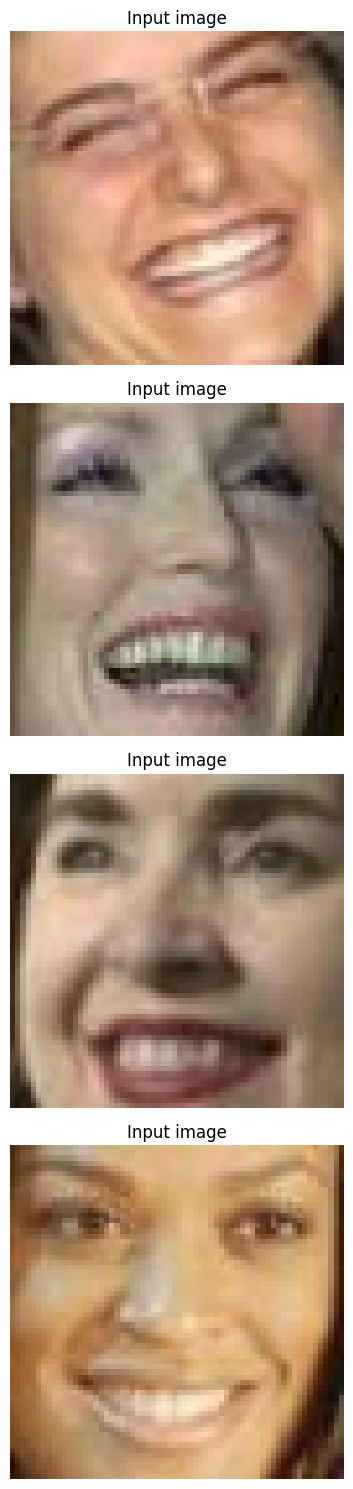

In [12]:
_, ax = plt.subplots(4, 1, figsize=(10, 15))
for i, img in enumerate(smile_ds.take(4)):
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i].imshow(img)
    ax[i].set_title("Input image")
    ax[i].set_title("Input image")
    ax[i].axis("off")

plt.tight_layout()
plt.show()

In [13]:
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
input_img_size = (64, 64, 3)


class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(
        self,
        padding=(1, 1),
        **kwargs
        ):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x

def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)


    num_filters = filters
    for num_downsample_block in range(num_downsampling):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model



    class CycleGan(keras.Model):
      def __init__(
          self,
          generator_G,
          generator_F,
          discriminator_X,
          discriminator_Y,
          lambda_cycle=10.0,
          lambda_identity=0.5,
      ):
          super(CycleGan, self).__init__()
          self.gen_G = generator_G
          self.gen_F = generator_F
          self.disc_X = discriminator_X
          self.disc_Y = discriminator_Y
          self.lambda_cycle = lambda_cycle
          self.lambda_identity = lambda_identity

      def compile(
          self,
          gen_G_optimizer,
          gen_F_optimizer,
          disc_X_optimizer,
          disc_Y_optimizer,
          gen_loss_fn,
          disc_loss_fn,
      ):
          super(CycleGan, self).compile()
          self.gen_G_optimizer = gen_G_optimizer
          self.gen_F_optimizer = gen_F_optimizer
          self.disc_X_optimizer = disc_X_optimizer
          self.disc_Y_optimizer = disc_Y_optimizer
          self.generator_loss_fn = gen_loss_fn
          self.discriminator_loss_fn = disc_loss_fn
          self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
          self.identity_loss_fn = keras.losses.MeanAbsoluteError()

      def train_step(self, batch_data):
          real_x, real_y = batch_data

          with tf.GradientTape(persistent=True) as tape:
              fake_y = self.gen_G(real_x, training=True)
              fake_x = self.gen_F(real_y, training=True)

              cycled_x = self.gen_F(fake_y, training=True)
              cycled_y = self.gen_G(fake_x, training=True)

              same_x = self.gen_F(real_x, training=True)
              same_y = self.gen_G(real_y, training=True)

              disc_real_x = self.disc_X(real_x, training=True)
              disc_fake_x = self.disc_X(fake_x, training=True)

              disc_real_y = self.disc_Y(real_y, training=True)
              disc_fake_y = self.disc_Y(fake_y, training=True)

              gen_G_loss = self.generator_loss_fn(disc_fake_y)
              gen_F_loss = self.generator_loss_fn(disc_fake_x)

              cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
              cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

              id_loss_G = (
                  self.identity_loss_fn(real_y, same_y)
                  * self.lambda_cycle
                  * self.lambda_identity
              )
              id_loss_F = (
                  self.identity_loss_fn(real_x, same_x)
                  * self.lambda_cycle
                  * self.lambda_identity
              )

              total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
              total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

              disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
              disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

          grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
          grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

          disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
          disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

          self.gen_G_optimizer.apply_gradients(
              zip(grads_G, self.gen_G.trainable_variables)
          )
          self.gen_F_optimizer.apply_gradients(
              zip(grads_F, self.gen_F.trainable_variables)
          )

          self.disc_X_optimizer.apply_gradients(
              zip(disc_X_grads, self.disc_X.trainable_variables)
          )
          self.disc_Y_optimizer.apply_gradients(
              zip(disc_Y_grads, self.disc_Y.trainable_variables)
          )

          return {
              "G_loss": total_loss_G,
              "F_loss": total_loss_F,
              "D_X_loss": disc_X_loss,
              "D_Y_loss": disc_Y_loss,
          }

      def fit(self, dataset, epochs, verbose=1):
          for epoch in range(epochs):
              print(f'Epoch {epoch+1}/{epochs}')
              prog_bar = tqdm(total=len(dataset))
              for batch_data in dataset:
                  logs = self.train_step(batch_data)
                  prog_bar.update(1)
                  prog_bar.set_postfix(G_loss=logs['G_loss'].numpy(),
                                      F_loss=logs['F_loss'].numpy(),
                                      D_X_loss=logs['D_X_loss'].numpy(),
                                      D_Y_loss=logs['D_Y_loss'].numpy())
              prog_bar.close()
              print(f"Epoch {epoch+1}/{epochs} - G_loss: {logs['G_loss'].numpy():.4f}, F_loss: {logs['F_loss'].numpy():.4f}, D_X_loss: {logs['D_X_loss'].numpy():.4f}, D_Y_loss: {logs['D_Y_loss'].numpy():.4f}")


In [14]:
# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [15]:
# Unhide cell output to view the generators and discriminators architecture.
# The output is very long so I've hidden it.

gen_G.summary(), gen_F.summary(), disc_X.summary(), disc_Y.summary()

Model: "generator_G"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 generator_G_img_input (Inp  [(None, 64, 64, 3)]          0         []                            
 utLayer)                                                                                         
                                                                                                  
 reflection_padding2d (Refl  (None, 70, 70, 3)            0         ['generator_G_img_input[0][0]'
 ectionPadding2D)                                                   ]                             
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           9408      ['reflection_padding2d[0][0]']
                                                                                        

(None, None, None, None)

Epoch 1/5



100%|██████████| 500/500 [23:50<00:00,  2.86s/it, D_X_loss=0.235, D_Y_loss=0.212, F_loss=2.25, G_loss=2.31]


Epoch 1/5 - G_loss: 2.3077, F_loss: 2.2469, D_X_loss: 0.2355, D_Y_loss: 0.2123
Epoch 2/5



100%|██████████| 500/500 [23:04<00:00,  2.77s/it, D_X_loss=0.168, D_Y_loss=0.192, F_loss=2.03, G_loss=1.99]


Epoch 2/5 - G_loss: 1.9934, F_loss: 2.0342, D_X_loss: 0.1679, D_Y_loss: 0.1917
Epoch 3/5



100%|██████████| 500/500 [26:32<00:00,  3.18s/it, D_X_loss=0.137, D_Y_loss=0.18, F_loss=2.22, G_loss=2.04]


Epoch 3/5 - G_loss: 2.0430, F_loss: 2.2238, D_X_loss: 0.1372, D_Y_loss: 0.1800
Epoch 4/5



100%|██████████| 500/500 [28:10<00:00,  3.38s/it, D_X_loss=0.136, D_Y_loss=0.16, F_loss=2.01, G_loss=1.95]


Epoch 4/5 - G_loss: 1.9471, F_loss: 2.0114, D_X_loss: 0.1364, D_Y_loss: 0.1603
Epoch 5/5



100%|██████████| 500/500 [27:18<00:00,  3.28s/it, D_X_loss=0.111, D_Y_loss=0.1, F_loss=2.06, G_loss=2.15]


Epoch 5/5 - G_loss: 2.1547, F_loss: 2.0645, D_X_loss: 0.1112, D_Y_loss: 0.1000


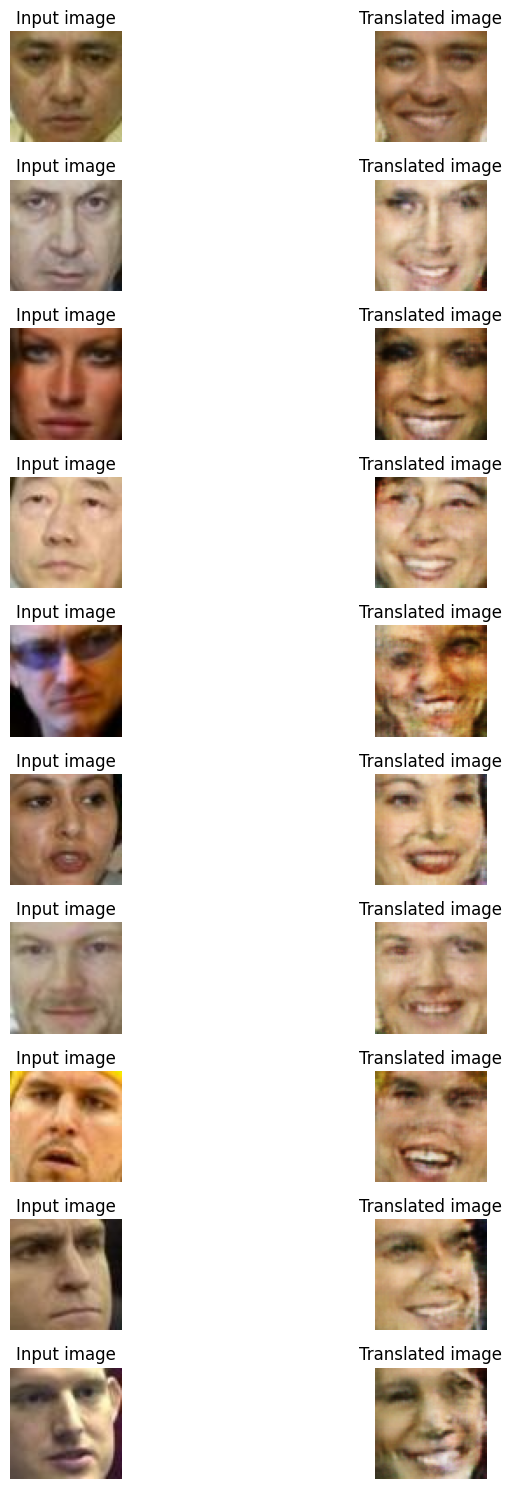

In [17]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tqdm import tqdm

# Define helper functions and classes
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer."""
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")

def residual_block(x, activation, kernel_initializer, kernel_size=(3, 3), strides=(1, 1), padding="valid", gamma_initializer=None, use_bias=False):
    dim = x.shape[-1]
    input_tensor = x
    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(dim, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding, use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)
    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(dim, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding, use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x

def downsample(x, filters, activation, kernel_initializer, kernel_size=(3, 3), strides=(2, 2), padding="same", gamma_initializer=None, use_bias=False):
    x = layers.Conv2D(filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer, padding=padding, use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

def upsample(x, filters, activation, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer=None, gamma_initializer=None, use_bias=False):
    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, kernel_initializer=kernel_initializer, use_bias=use_bias)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

def get_resnet_generator(filters=64, num_downsampling_blocks=2, num_residual_blocks=9, num_upsample_blocks=2, gamma_initializer=None, name=None):
    img_input = layers.Input(shape=(64, 64, 3), name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"), kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02))
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"), kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), gamma_initializer=gamma_initializer)
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"), kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.02), gamma_initializer=gamma_initializer)
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)
    model = keras.models.Model(img_input, x, name=name)
    return model

def get_discriminator(filters=64, kernel_initializer=None, num_downsampling=3, name=None):
    img_input = layers.Input(shape=(64, 64, 3), name=name + "_img_input")
    x = layers.Conv2D(filters, (4, 4), strides=(2, 2), padding="same", kernel_initializer=kernel_initializer)(img_input)
    x = layers.LeakyReLU(0.2)(x)
    num_filters = filters
    for num_downsample_block in range(num_downsampling):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4, 4), strides=(2, 2), kernel_initializer=kernel_initializer)
        else:
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4, 4), strides=(1, 1), kernel_initializer=kernel_initializer)
    x = layers.Conv2D(1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer)(x)
    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.gen_G(real_x, training=True)
            fake_x = self.gen_F(real_y, training=True)

            cycled_x = self.gen_F(fake_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

    def fit(self, dataset, epochs, steps_per_epoch, verbose=1):
        for epoch in range(epochs):
            print(f'Epoch {epoch+1}/{epochs}')
            prog_bar = tqdm(total=steps_per_epoch)
            step = 0
            while step < steps_per_epoch:
                for batch_data in dataset:
                    if step >= steps_per_epoch:
                        break
                    logs = self.train_step(batch_data)
                    prog_bar.update(1)
                    prog_bar.set_postfix(G_loss=logs['G_loss'].numpy(),
                                         F_loss=logs['F_loss'].numpy(),
                                         D_X_loss=logs['D_X_loss'].numpy(),
                                         D_Y_loss=logs['D_Y_loss'].numpy())
                    step += 1
            prog_bar.close()
            print(f"Epoch {epoch+1}/{epochs} - G_loss: {logs['G_loss'].numpy():.4f}, F_loss: {logs['F_loss'].numpy():.4f}, D_X_loss: {logs['D_X_loss'].numpy():.4f}, D_Y_loss: {logs['D_Y_loss'].numpy():.4f}")

# Instantiate and compile the CycleGAN model
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

adv_loss_fn = keras.losses.MeanSquaredError()

def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss

def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

# Define your dataset
# non_smile_ds and smile_ds should be previously defined TensorFlow datasets

# Train the model
cycle_gan_model.fit(
    tf.data.Dataset.zip((non_smile_ds, smile_ds)),
    epochs=5,
    steps_per_epoch=500
)
_, ax = plt.subplots(10, 2, figsize=(10, 15))
for i, img in enumerate(non_smile_ds.take(10)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    # prediction = keras.preprocessing.image.array_to_img(prediction)
    # prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()